# Pytorch and autodiff basics

Adapted from: http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
and CSCS-ICS-DADSi Summer School: Accelerating Data Science with HPC, September 4 - 6, 2017, Swiss National Supercomputing Centre

This notebook shows how to use PyTorch's (http://pytorch.org/) autodifferentiation, and also trains a simple classifier on the MNIST dataset.

## Part 1: Tensors

We start by importing `torch`.

In [1]:
import torch

Tensors, or multi-dimensional arrays, are the basic unit in PyTorch. Let's create a 5x3 matrix as a 2-dimensional Tensor. This will default to a `FloatTensor`, a tensor of single-precision (32-bits) floating point numbers. The tensor will be initialized with random numbers.

In [2]:
x = torch.Tensor(3,5,3)
print(x)

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.4013e-45, 0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.4013e-45, 0.0000e+00, 1.4013e-45],
         [0.0000e+00, 1.4013e-45, 0.0000e+00],
         [1.4013e-45, 0.0000e+00, 0.0000e+00]]])


### Slicing

It is common to have higher-dimensional tensors, to hold all aspects of your data together, such as a 3x200x200 tensor holding the R,G,B channels of an image of 200x200 pixels, or a 100x3x200x200 tensor to hold a batch of 100 such images.

We use slicing operations to view specific subtensors of such a tensor. Note that PyTorch uses zero-based indexing and row-major memory ordering.

In [3]:
# 100 images of 3 channels of size 200x200
x = torch.Tensor(100,3,200,200)
print(x.size())

# Second channel of the first image
y = x[0,1]
print(y.size())

torch.Size([100, 3, 200, 200])
torch.Size([200, 200])


### Numpy conversion

You might have noticed that Tensors are very similar to Numpy's ndarrays. In fact you can easily convert between ndarrays and Tensors.

In [4]:
x_np = x.numpy()
print(x_np.shape)

x = torch.from_numpy(x_np)
print(x.size())

(100, 3, 200, 200)
torch.Size([100, 3, 200, 200])


### A note on GPU usage

PyTorch is frequently used with a CUDA backend on a GPU. One would convert between tensors and CUDA tensors by simply calling

`x.cuda()`

`x.cpu()`

which transfer data to and from a GPU memory.

You can check if CUDA is available by using:

In [5]:
torch.cuda.is_available()

False

## Part 2: Automatic differentiation

PyTorch implements reverse-mode automatic differentiation (AD).

With AD, obtaining a gradient of a scalar-valued function is straightforward. Let's use the regular Python language features to define a function.

In [6]:
def f(x):
    y = torch.log(x[0]) + torch.sin(x[1])
    return x[2] * torch.exp(y)

Let's evaluate the gradient of `f(x)` at `x = [2,3,4]`.

In [7]:
x = torch.tensor([2.,3,4], requires_grad=True)
y = f(x)
print(y)

y.backward()# evaluates the gradient of y wrt to the graph leaves (x in this case)
print(x.grad)# gradients are accumulated in the .grad attribute of the leaf tensors

tensor(9.2125, grad_fn=<MulBackward0>)
tensor([ 4.6063, -9.1203,  2.3031])


Note that we get the function evaluated `f(2,3,4)` as `9.2125` and the gradient `f'(2,3,4)` as `[4.6063, -9.1203, 2.3031]`.

Also note the use of `requires_grad = True` for tagging the tensor `x` for being differentiated with respect to. This is for efficiency reasons, allowing PyTorch to ignore the bookkeeping for tensors whose derivatives we don't need.

In [8]:
y = f(x)
y.backward()
print(x.grad)# note, the grad attribute is not reset every time .backward is called, 
# so it can accumulate if you are not careful! (see more here: https://pytorch.org/docs/stable/autograd.html)

tensor([  9.2125, -18.2406,   4.6063])


## Part 3: Neural networks

The previous two parts, namely defining and using tensors and being able to obtain derivatives, give us everything needed for constructing and training a neural network.

### Defining a neural network

A very important point to note is that **neural networks are just functions, and there is nothing special about them.**

A neural network is a series of linear algebra operations interleaved with non-linear transformations. Let's create a single feed-forward layer with two neurons connected to four inputs (note that this omits the bias term for simplicity).

In [9]:
def run_layer(weights, inputs):
    outputs = torch.mm(weights, inputs)
    outputs = torch.tanh(outputs)
    return outputs

W = torch.randn(2,4, requires_grad=True) # A 2x4 weight matrix
x = torch.tensor([[1.],[2],[3],[4]]) # A column vector of length four

y = run_layer(W, x)
print(y)

tensor([[0.5909],
        [0.9968]], grad_fn=<TanhBackward>)


### The loss function

Training this neural network layer would simply mean taking the derivative of a loss function at its output with respect to its trainable weights (the matrix `W` above).

In [10]:
def loss(outputs, targets):
    return torch.mean((outputs - targets)**2)

W = torch.randn(2,4, requires_grad=True) # A 2x4 weight matrix
x = torch.tensor([[1.],[2],[3],[4]]) # A column vector of length four

loss = loss(run_layer(W, x), torch.tensor([1.,1]))
print(loss)

loss.backward()

W_grad = W.grad
print(W_grad)

tensor(5.2580e-13, grad_fn=<MeanBackward0>)
tensor([[-1.3927e-12, -2.7853e-12, -4.1780e-12, -5.5707e-12],
        [-7.1054e-13, -1.4211e-12, -2.1316e-12, -2.8422e-12]])


### Optimization

We would then iteratively update the weights in a gradient-based update rule.

In [11]:
learning_rate = 0.000001
W = W - learning_rate * W_grad
print(W)

tensor([[ 0.6610,  1.1173, -0.5417,  1.5181],
        [-1.4411,  1.8762, -0.2525,  1.4904]], grad_fn=<SubBackward0>)


By taking the gradient of a neural network with respect to its trainable parameters (weights), we can optimize it with gradient descent.

## Using torch.nn modules

In practice, unless you are implementing new neural network architectures, you would use the existing neural network building blocks provided by the `torch.nn` module, which internally work similar to the basic example we covered above.

We will now define a convolutional neural network for image recognition on the MNIST dataset and train and test it, using the regular PyTorch workflow. The MNIST dataset is a collection of 60,000 images of handwritten digits labeled as belonging to one of the ten digit categories.

First we load the MNIST dataset. We also apply preprocessing for normalizing data.

We divide the data into training and test sets.

In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_dataset = datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

> **Task 1**: write some code to visualise some of the training examples and their labels.

> **Question**: how many examples are there in the training and test datasets?

60000
10000


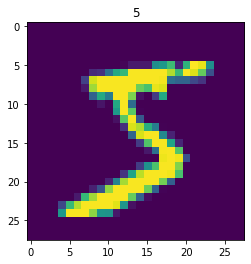

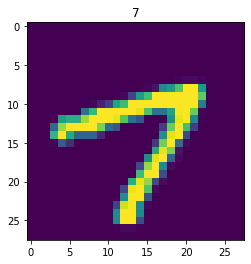

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# TODO: write some code here

print(len(train_dataset))
print(len(test_dataset))

for i in [0, 101]:
    im,label = train_dataset[i]
    
    plt.imshow(im.numpy()[0])
    plt.title(label)
    plt.show()

Next we define our neural network composed of two convolutional layers followed by max-pooling layers and two fully-connected (linear) layers.

Note that we only need to 
- create the layer modules (in the `__init__` constructor) and 
- define the function for the forward run of the network (in the `forward` method)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self): # The definition of neural network layers
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x): # The function for forward evaluation
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
    
model = Net()

> **Question**: What are the dimensions of the inputs and outputs of `model(x)`? What are the dimensions of its hidden layers?

Finally we train the network.
We use the stochastic gradient descent (SGD) optimization routine provided by the `torch.optim` module. We use a learning rate of `0.0001` and a momentum of `0.9`.

In [15]:
from torch import optim

optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)# this automatically batches up examples, adding a batch dimension
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

> **Task 2**: write two functions to train and test the network. 

Note: as this is a classification task, we want to pass the output tensor of the network through a softmax function to get class probability predictions, and then use cross entropy for the loss function. I.e., class probability predictions should be computed using `model(x).softmax(dim=1)`.

In [16]:
def train(epoch):
    model.train()
    
    # TODO: write some code here
    
    # pseudocode:
    
    # for each batch in train_loader
        # carry out a forward pass of the network
        # compute the loss function (use cross-entropy)
        # compute the gradient wrt to the network weights
        # carry out an optimisation step (hint: you can use optimizer.step())
        # after every 100 batches, print out the current epoch number, batch number and loss value
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test():
    model.eval()
    
    # TODO: write some code here
    
    # pseudocode:
    
    # print out the test loss value averaged over the whole test dataset
    # assuming the class with the highest predicted probability as the predicted label,
    # print the fraction of correctly predicted labels (accuracy) over the whole test dataset
    
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()
        pred = output.max(dim=1)[1] # get the index of the max probability
        correct += pred.eq(target).cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

We train the neural network for four epochs. 

As training progresses, you will see that the classification accuracy in the test set will keep rising. At the end of four epochs, we will have an accuracy of around 85% in the test set.

In [17]:
for epoch in range(1, 5):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298136
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.300483
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.302973
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.291504
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.277267
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.248577
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.237403
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.250525
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.223656
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.212366

Test set: Average loss: 2.1792, Accuracy: 4336/10000 (43%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.225918
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.203087
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.117291
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.131106
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.029713
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.136185
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.962847
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.871894
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.724340
T

Let's test some images from the test set. You can evaluate the same cell many times to visualize results for more test images.

> **Task 3**: write some code to visualise the predicted class probabilites for some of the test images.

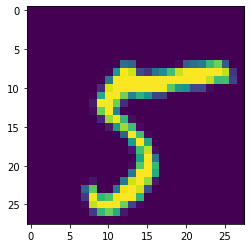

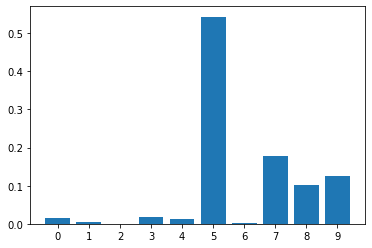

In [18]:
# TODO: write some code here
    
import itertools
index = 12
a = list(itertools.islice(test_loader, index))
test_image = a[0][0][0]
test_label = a[0][1][0]

test_output = model(test_image.unsqueeze(0)).softmax(dim=1).detach()

plt.imshow(test_image[0].numpy())
plt.show()

fig, ax = plt.subplots()
ax.bar(range(10), test_output[0])
ax.set_xticks(np.arange(10))
plt.show()

## Extensions

> **Extension 1**: change the network design by adding dropout layers after the convolutional layers. How does this affect performance?

> **Extension 2**: Use the Adam optimiser instead of SGD, how does this affect performance?

> **Extension 3**: How high can the learning rate go before training becomes unstable?